### 1. Dependencias y Configuración Entorno

In [70]:
# 1.1 Librerías Principales
import numpy as np
import pandas as pd

# 1.2 Librerías Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# 1.3 Otras Librerías
from functools import reduce

# 1.4 Customization del NoteBook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1.5 Direccionamiento Paths
pathRoot  = "../"
pathCSV   = pathRoot + "DatosProyecto/bank-additional.csv"
pathExcel = pathRoot + "DatosProyecto/customer-details.xlsx"
pathNewData = pathRoot + "DatosProyecto/DatosFiltrados.xlsx"

### 2. Definición de Funciones

In [71]:
# 2.1 Función `extraerElementoFecha(fecha, elemento)` 
def extraerElementoFecha(fecha, elemento):
    """
    A partir de a) y b), devolvemos el elemento que se busca en formato String.:  
        a) Una fecha en string con formato 'dd-mm-yyyy' 
        b) Un elemento 'd', 'm' o 'y'    
    Ej: extraerElementoFecha("19-Noviembre-2025", "d") -> "19"  
    Ej: extraerElementoFecha("19-Noviembre-2025", "m") -> "Noviembre"  
    Ej: extraerElementoFecha("19-Noviembre-2025", "y") -> "2025"  
    """
    if isinstance(fecha, str) and isinstance(elemento, str):
        try:
            day, month, year = fecha.split("-")
            if elemento.lower()=="d":
                return day
            elif elemento.lower() == "m":
                if month.lower()=='enero':
                    month = 1
                elif month.lower()=='febrero':
                    month = 2
                elif month.lower()=='marzo':
                    month = 3
                elif month.lower()=='abril':
                    month = 4
                elif month.lower()=='mayo':
                    month = 5
                elif month.lower()=='junio':
                    month = 6
                elif month.lower()=='julio':
                    month = 7
                elif month.lower()=='agosto':
                    month = 8
                elif month.lower()=='septiembre':
                    month = 9
                elif month.lower()=='octubre':
                    month = 10
                elif month.lower()=='noviembre':
                    month = 11
                elif month.lower()=='diciembre':
                    month = 12
                return (int)(month)
            elif elemento.lower() == "y":
                return year
        except ValueError:
            raise ValueError("Algun valor no es correcto, el elemento debe ser 'd', 'm' o 'y', y la fecha correcta 'd-m-y'.")
    else:
        return None

### 3. Procesamiento de Archivos

#### 3.1. Preparación Inicial `.XLSX`

In [72]:
# 3.1.1 Identificación Hojas  
hojasExcel = pd.ExcelFile(pathExcel)

# Introducimos todas las hojas en una lista
contenedorHojas = []
for hoja in hojasExcel.sheet_names:
    contenedorHojas.append(pd.read_excel(pathExcel, sheet_name = hoja)) 

# 3.1.2 Comprobación Columnas entre Hojas
columnasOk = True
for i in range(len(contenedorHojas)-1):
    if not contenedorHojas[i].columns.equals(contenedorHojas[i+1].columns):
        columnasOk = False

# 3.1.3 Concatenación Hojas en DataFrame `df1` y Check Dimensiones
if columnasOk:
    df1 = pd.concat(contenedorHojas, ignore_index=True)
else:
    print("Las columnas entre las hojas no coinciden, por lo que no se procede a la unión del documento.")

#### 3.2. Preparación Inicial `.CSV`

In [73]:
# 3.2.1 Transformación en DataFrame `df2` y Check Dimensiones  
df2 = pd.read_csv(pathCSV)

### 3.3. Preparación para Unificar DataFrames con `.Merge()`

In [74]:
# 3.3.1 Identificación Columnas en `df1` y `df2`  
print(list(df1.columns))
print(list(df2.columns))

['Unnamed: 0', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'NumWebVisitsMonth', 'ID']
['Unnamed: 0', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'date', 'latitude', 'longitude', 'id_']


In [75]:
# 3.3.2 Comprobación Duplicados en `df1` y `df2`
temp = df1.drop(columns=["ID","Unnamed: 0"])
print(f"Elementos duplicados: {temp.duplicated().sum()}")

temp = df2.drop(columns=["id_","Unnamed: 0"])
print(f"Elementos duplicados: {temp.duplicated().sum()}")

Elementos duplicados: 0
Elementos duplicados: 0


In [76]:
# 3.3.3 Corrección Columnas en DataFrames

# He visto columnas incorrectas, por ejemplo:
#   - Columna "Unnamed: 0", se le cambia el nombre por position
#   - Columna "ID" e "id_": se cambian por un valor común, es la columna que usaré para casar ambas tablas
df1.rename(columns={"ID" : "id", "Unnamed: 0": "position"}, inplace=True)
df2.rename(columns={"id_": "id", "Unnamed: 0": "position"}, inplace=True)

# Aprovecho para poner en minúsculas y sin espacios prev/post a todas las columnas y evitar así problemas case sensitive
df1.columns = df1.columns.str.lower().str.strip()
df2.columns = df2.columns.str.lower().str.strip()

print(f"Las columnas del DataFrame1 son: {list(df1.columns)}")
print(f"Las columnas del DataFrame2 son: {list(df2.columns)}")

Las columnas del DataFrame1 son: ['position', 'income', 'kidhome', 'teenhome', 'dt_customer', 'numwebvisitsmonth', 'id']
Las columnas del DataFrame2 son: ['position', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'date', 'latitude', 'longitude', 'id']


In [77]:
# 3.3.4 Creación Columnas `contact_month` y `contact_year`

# Busco posición columna "date" e información sobre ella
print(f"""La columna 'date' está en la posición: {df2.columns.get_loc("date")}
Los datos dentro de la columna 'date' son de tipo {type(df2["date"][1])} y tiene el siguiente formato: {df2["date"][1]}.
""")

# Añado las nuevas columnas, utilizo función lambda para aplicar a cada línea de la DataFrame la función `extraerElementosFecha(fecha, elemento)`
df2.insert(21, "contact_day", df2["date"].apply(lambda x: extraerElementoFecha(x, 'd')))
df2.insert(22, "contact_month", df2["date"].apply(lambda x: extraerElementoFecha(x, 'm')))
df2.insert(23, "contact_year",  df2["date"].apply(lambda x: extraerElementoFecha(x, 'y')))

# Reviso que las columnas estén correctamente creadas
print(f"""La columna 'contact_day' está ubicada en la posición {df2.columns.get_loc("contact_day")}
La columna 'contact_month' está ubicada en la posición {df2.columns.get_loc("contact_month")}
La columna 'contact_year'  está ubicada en la posición {df2.columns.get_loc("contact_year")}""")

La columna 'date' está en la posición: 20
Los datos dentro de la columna 'date' son de tipo <class 'str'> y tiene el siguiente formato: 14-septiembre-2016.

La columna 'contact_day' está ubicada en la posición 21
La columna 'contact_month' está ubicada en la posición 22
La columna 'contact_year'  está ubicada en la posición 23


In [78]:
# 3.3.5 Comprobación Dimensiones Tablas

# Antes de hacer el merge, compruebo la longitud de ambas tablas
print(df1.shape)
print(df2.shape)

(43170, 7)
(43000, 27)


In [79]:
# 3.3.6 Unión de DataFrames

# He observado que las dimensiones de los dos archivos difieren, los datos
# más importantes están en el df2. Por lo que vamos a realizar un conexionado "inner"
# para enlazar solo aquellos datos que estén relacionados entre sí.
df = pd.merge(df2, df1, on="id", how="inner")

print(df.shape)
df.head(0)

(43000, 33)


,position_x,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,date,contact_day,contact_month,contact_year,latitude,longitude,id,position_y,income,kidhome,teenhome,dt_customer,numwebvisitsmonth


In [80]:
# Al unir las dos tablas, se han creado dos índices. Eliminamos el indice que no nos interesa y renombramos el otro.
df.drop(columns=['position_y'], inplace=True)
df.rename(columns={"position_x": "position"}, inplace=True)

print(df.shape)
df.head(0)

(43000, 32)


,position,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,date,contact_day,contact_month,contact_year,latitude,longitude,id,income,kidhome,teenhome,dt_customer,numwebvisitsmonth


### 3.4. Limpieza de Datos

In [81]:
# 3.4.1 Comprobación Columnas (NaN, Tipo Dato)  

dfNanValues = []
dfTypes = []
for i in list(df.columns):
    dfNanValues.append((int)(df[i].isna().sum()))
    dfTypes.append(df[i].dtypes)

tablaNaN = pd.DataFrame({
    "Valor": list(df.columns),
    "Número": dfNanValues,
    "Tipo Dato": dfTypes
})
tablaNaN

,Valor,Número,Tipo Dato
0,position,0,int64
1,age,5120,float64
2,job,345,object
3,marital,85,object
4,education,1807,object
5,default,8981,float64
6,housing,1026,float64
7,loan,1026,float64
8,contact,0,object
9,duration,0,int64


In [82]:
# 3.4.2 Creación Copia antes de Limpieza Datos
dfNew = df.copy()

In [83]:
# 3.4.3  Corrección Tipos de Dato

# Corregimos los valores de `cons.conf.idx`
if dfNew['cons.conf.idx'].dtype.kind != 'f':
    dfNew['cons.conf.idx'] = (dfNew['cons.conf.idx'].str.replace(',', '.', regex=False).astype(float))


# Corregimos los valores de `cons.price.idx`
if dfNew['cons.price.idx'].dtype.kind != 'f':
    dfNew['cons.price.idx'] = (dfNew['cons.price.idx'].str.replace(',', '.', regex=False).astype(float))


# Corregimos los valores de `euribor3m`
if dfNew['euribor3m'].dtype.kind != 'f':
    dfNew['euribor3m'] = (dfNew['euribor3m'].str.replace(',', '.', regex=False).astype(float))


# Corregimos los valores de `age`
if dfNew['age'].dtype.kind != 'i':
    dfNew['age'] = (dfNew['age'].astype('Int64'))


# Corregimos los valores de `default`
if dfNew['default'].dtype.kind != 'i':
    dfNew['default'] = (dfNew['default'].astype('Int64'))


# Corregimos los valores de `housing`
if dfNew['housing'].dtype.kind != 'i':
    dfNew['housing'] = (dfNew['housing'].astype('Int64'))
    

# Corregimos los valores de `loan`
if dfNew['loan'].dtype.kind != 'i':
    dfNew['loan'] = (dfNew['loan'].astype('Int64'))


# Corregimos los valores de `nr.employed`
if dfNew['nr.employed'].dtype.kind != 'f':
    dfNew['nr.employed'] = (dfNew['nr.employed'].str.replace(',', '.', regex=False).astype(float))




##########      Date    ##########

# Corregimos los valores de `contact_day`
if dfNew['contact_day'].dtype.kind != 'i':
    dfNew['contact_day'] = (dfNew['contact_day'].astype('Int64'))

# Corregimos los valores de `contact_month`
if dfNew['contact_month'].dtype.kind != 'i':
    dfNew['contact_month'] = (dfNew['contact_month'].astype('Int64'))

# Corregimos los valores de `contact_year`
if dfNew['contact_year'].dtype.kind != 'i':
    dfNew['contact_year'] = (dfNew['contact_year'].astype('Int64'))




# Ahora que tengo los datos corregidos del día de contacto, pasamos a reconstruir date con un formato DateTime
mask = dfNew[['contact_year', 'contact_month', 'contact_day']].notna().all(axis=1)

# Construimos un string 'YYYY-MM-DD' solo para esas filas
fecha_str = (
    dfNew.loc[mask, 'contact_year'].astype('int').astype(str) + '-' +
    dfNew.loc[mask, 'contact_month'].astype('int').astype(str).str.zfill(2) + '-' +
    dfNew.loc[mask, 'contact_day'].astype('int').astype(str).str.zfill(2)
)

dfNew.loc[mask, 'date'] = pd.to_datetime(fecha_str, errors='coerce').dt.date
dfNew['dt_customer'] = pd.to_datetime(dfNew['dt_customer'], errors='coerce').dt.date


In [84]:
# 3.4.4  Relleno Huecos Vacíos

# Los datos 'Job', 'marital' y 'education', vamos a darle un valor unknown.
dfNew['job']       = dfNew['job'].fillna("unknown")
dfNew['marital']   = dfNew['marital'].fillna('unknown')
dfNew['education'] = dfNew['education'].fillna('unknown')

In [85]:
# 3.4.4  Busqueda correlación entre `euribor3m` y `emp.var.rate`
dfNew[['emp.var.rate', 'euribor3m']].corr()

# He visto una fuerte relación entre un conjunto de datos 'emp.var.rate','cons.price.idx`, `cons.conf.idx` y `euribor3m`
# Es por ello que voy a proceder, en relación a estos datos a rellenar los 9256 valores NaN del euribor con su anterior y posterior si estos datos son correctos.
dfNew['euribor3m'] = (
    dfNew.groupby(['emp.var.rate', 'cons.price.idx', 'cons.conf.idx'])['euribor3m']
         .transform(lambda x: x.ffill().bfill())
)

# Ahora que solo faltan 471 datos de `euribor3m` y `cons.price.idx`, voy a proceder a rellenarlos según su anterior y posterior.
# Es decir, primero hemos hecho un relleno más controlado y seguro, y ahora vamos a proceder a rellenar los pocos datos faltantes.

dfNew['euribor3m'] = dfNew['euribor3m'].ffill().bfill()
dfNew['cons.price.idx'] = dfNew['cons.price.idx'].ffill().bfill()


### 3.5 Exportación Datos a Excel

In [86]:
dfNew.to_excel(pathNewData, index=False)

### 4. Analisis de Datos 

#### 4.1 Descripción Datos

In [87]:
dfNew.describe().T

,count,mean,std,min,25%,50%,75%,max
position,43000.0,20651.099047,11868.770913,0.0,10381.75,20642.5,30930.25,41187.0
age,37880.0,39.977112,10.437957,17.0,32.0,38.0,47.0,98.0
default,34019.0,0.000088,0.00939,0.0,0.0,0.0,0.0,1.0
housing,41974.0,0.535998,0.498708,0.0,0.0,1.0,1.0,1.0
loan,41974.0,0.15562,0.362499,0.0,0.0,0.0,0.0,1.0
duration,43000.0,257.739279,258.666033,0.0,102.0,179.0,319.0,4918.0
campaign,43000.0,2.567233,2.772294,1.0,1.0,2.0,3.0,56.0
pdays,43000.0,962.330953,187.260394,0.0,999.0,999.0,999.0,999.0
previous,43000.0,0.174023,0.497366,0.0,0.0,0.0,0.0,7.0
emp.var.rate,43000.0,0.077128,1.573898,-3.4,-1.8,1.1,1.4,1.4


In [88]:
dfNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43000 entries, 0 to 42999
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   position           43000 non-null  int64  
 1   age                37880 non-null  Int64  
 2   job                43000 non-null  object 
 3   marital            43000 non-null  object 
 4   education          43000 non-null  object 
 5   default            34019 non-null  Int64  
 6   housing            41974 non-null  Int64  
 7   loan               41974 non-null  Int64  
 8   contact            43000 non-null  object 
 9   duration           43000 non-null  int64  
 10  campaign           43000 non-null  int64  
 11  pdays              43000 non-null  int64  
 12  previous           43000 non-null  int64  
 13  poutcome           43000 non-null  object 
 14  emp.var.rate       43000 non-null  float64
 15  cons.price.idx     43000 non-null  float64
 16  cons.conf.idx      430

##### 4.2. Éxito Por Campaña

In [89]:
# 4.2.1  Tabla Datos

tabla = dfNew.groupby('campaign')['y'].value_counts().unstack(fill_value=0)
tabla['% Éxito'] = round(tabla['yes'] / (tabla['yes'] + tabla['no']) * 100, 2)
tabla['Media_Euribor'] = dfNew.groupby('campaign')['euribor3m'].mean().round(3)

tabla

y,no,yes,% Éxito,Media_Euribor
campaign,,,,
1,16008,2396,13.02,3.419
2,9780,1268,11.48,3.575
3,4980,604,10.82,3.802
4,2519,258,9.29,3.821
5,1535,123,7.42,3.816
6,946,79,7.71,3.843
7,618,40,6.08,4.008
8,398,20,4.78,4.051
9,273,16,5.54,4.365


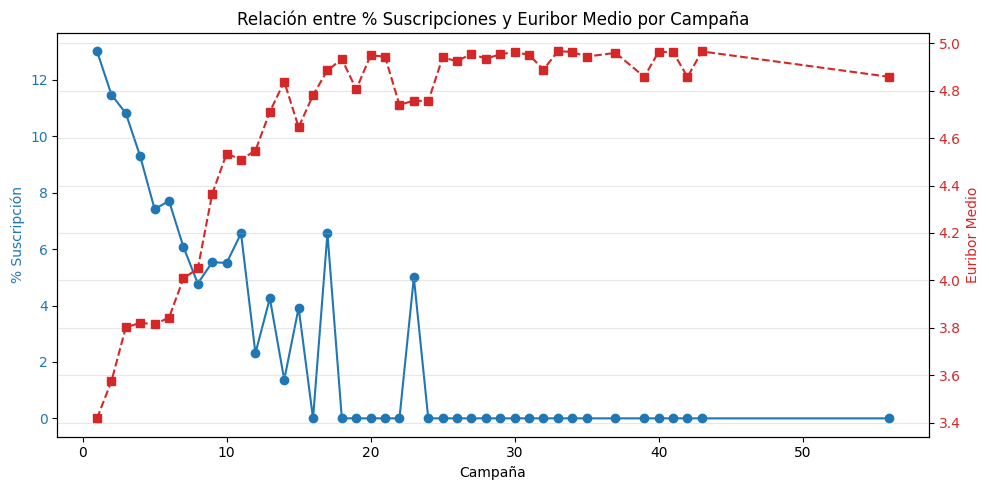

In [90]:
# 4.2.2  Gráfica Datos

# Agrupamos por campaña
tabla = dfNew.groupby('campaign').agg(
    total_yes=('y', lambda x: (x == 'yes').sum()),
    total_no=('y', lambda x: (x == 'no').sum()),
    euribor_mean=('euribor3m', 'mean')
)

# Calculamos el porcentaje de éxito
tabla['pct_suscripcion'] = round((tabla['total_yes'] / (tabla['total_yes'] + tabla['total_no'])) * 100,2)

# Dibujamos la gráfica
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel('Campaña')
ax1.set_ylabel('% Suscripción', color=color)
ax1.plot(tabla.index, tabla['pct_suscripcion'], marker='o', color=color, label='% Éxito')
ax1.tick_params(axis='y', labelcolor=color)

# Eje secundario para Euribor medio
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Euribor Medio', color=color)
ax2.plot(tabla.index, tabla['euribor_mean'], marker='s', linestyle='--', color=color, label='Euribor Medio')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Relación entre % Suscripciones y Euribor Medio por Campaña')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 4.3. Clientes Suscritos 

In [91]:
# Calculamos la cantidad de clientes suscritos
dfNew['y'].value_counts()

clientesSuscritos = dfNew[dfNew["y"]=="yes"]

# Segundo: Miramos de los clientes suscritos, cuales aportan edad y cuales no.
print(f"Clientes suscritos con registros de edad = {clientesSuscritos["age"].count()}")
print(f"Clientes suscritos sin registros de edad = {clientesSuscritos["age"].isnull().sum()}\n")

Clientes suscritos con registros de edad = 4266
Clientes suscritos sin registros de edad = 578



In [92]:
# 4.1.1. Clasificación por Edad
clientesSuscritosConEdad = clientesSuscritos[clientesSuscritos["age"]>0]

print(f"Cliente más Joven: {  (int)(clientesSuscritosConEdad["age"].min())}")    #17 años
print(f"Cliente más Mayor: {  (int)(clientesSuscritosConEdad["age"].max())}\n")  #98 años
print(f"Edad media: {         round(clientesSuscritosConEdad["age"].mean(),2)}") #40.89 años
print(f"Desviación Estandar: {round(clientesSuscritosConEdad["age"].std(),2)}")  #13.82 años
print(f"Varianza: {           round(clientesSuscritosConEdad["age"].var(),2)}")  #191.091

Cliente más Joven: 17
Cliente más Mayor: 98

Edad media: 40.89
Desviación Estandar: 13.82
Varianza: 191.09


##### 4.3.1. Cálculo Clientes Contactados Vs Suscritos

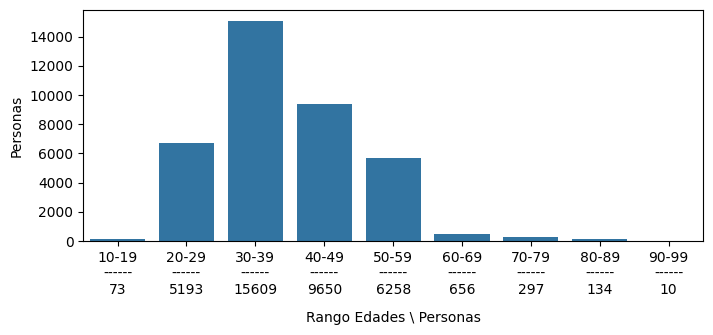

In [93]:
# 4.3.1.1. Gráfica Clientes Contactados

franjaEdades = range(10, 101, 10)  # 10-19, 20-29, ..., 90-99

etiquetas = []
for i in franjaEdades[:-1]:
    etiquetas.append(f"{i}-{i+9}\n------\n{dfNew[dfNew['age'].between(i,i+9)]['id'].count()}")

personas_contactadas = pd.cut(dfNew["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()

plt.figure(figsize=(8,3))
sns.barplot(x=personas_contactadas.index, y=personas_contactadas.values)
plt.ylabel("Personas")
plt.xlabel(f"Rango Edades \\ Personas", labelpad=10.0, loc="center")
plt.xticks(rotation=0)
plt.show()


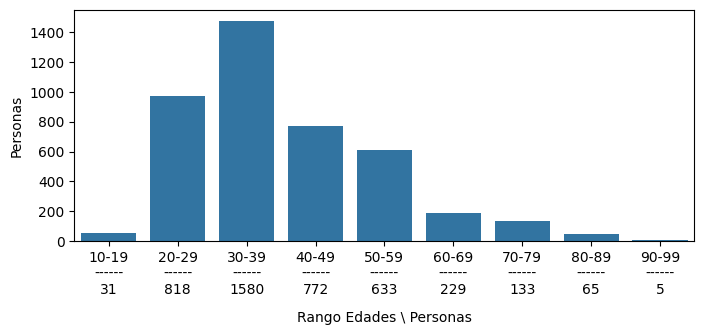

In [94]:
# 4.3.1.2. Gráfica Clientes Suscritos

etiquetas = []
for i in franjaEdades[:-1]:
    etiquetas.append(f"{i}-{i+9}\n------\n{clientesSuscritos[clientesSuscritos['age'].between(i,i+9)]['id'].count()}")

conteos_total = pd.cut(clientesSuscritos["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()

plt.figure(figsize=(8,3))
sns.barplot(x=conteos_total.index, y=conteos_total.values)
plt.ylabel("Personas")
plt.xlabel(f"Rango Edades \\ Personas", labelpad=10.0, loc="center")
plt.xticks(rotation=0)
plt.show()

In [95]:
# 4.3.1.3. Cálculo % de Contratación por Edad

# Duplico todo esto para que tenga sentido la tabla inferior
etiquetas = []
for i in franjaEdades[:-1]:
    etiquetas.append(f"{i}-{i+9}")

conteos_suscritos = pd.cut(clientesSuscritos["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()
conteos_total = pd.cut(df["age"], bins=franjaEdades, labels=etiquetas, right=True).value_counts().sort_index()

# Necesito ver 9 filas
pd.set_option('display.max_rows', 9)

# % Conversión
conversion = ((conteos_suscritos / conteos_total) * 100).round(2)

# Tabla resumen
edad_stats = pd.DataFrame({"Contactados": conteos_total, "Suscritos": conteos_suscritos, "% Suscripción": conversion})
edad_stats

,Contactados,Suscritos,% Suscripción
age,,,
10-19,136,55,40.44
20-29,6735,973,14.45
30-39,15071,1477,9.80
40-49,9378,771,8.22
50-59,5714,611,10.69
60-69,445,191,42.92
70-79,288,136,47.22
80-89,103,47,45.63
90-99,10,5,50.00


##### 4.3.2. Análisis Clientes Suscritos

In [96]:
# 4.3.2.1  Criterio Por Trabajo
tabla = dfNew.groupby(['job'])['y'].value_counts().unstack(fill_value=0)
tabla['% Éxito'] = round(tabla['yes'] / (tabla['yes'] + tabla['no']) * 100, 2)
tabla.sort_values('% Éxito', ascending=False)

y,no,yes,% Éxito
job,,,
student,620,283,31.34
retired,1339,451,25.20
unemployed,910,153,14.39
admin.,9458,1415,13.01
...,...,...,...
housemaid,1012,111,9.88
entrepreneur,1396,126,8.28
services,3826,336,8.07
blue-collar,8989,665,6.89


In [97]:
# 4.3.2.2  Criterio Por Estado Civil
tabla = dfNew.groupby(['marital'])['y'].value_counts().unstack(fill_value=0)
tabla['% Éxito'] = round(tabla['yes'] / (tabla['yes'] + tabla['no']) * 100, 2)
tabla.sort_values('% Éxito', ascending=False)

y,no,yes,% Éxito
marital,,,
unknown,72,13,15.29
SINGLE,10419,1686,13.93
MARRIED,23344,2655,10.21
DIVORCED,4321,490,10.18


In [98]:
# 4.3.2.3  Criterio Por Estudios
tabla = dfNew.groupby(['education'])['y'].value_counts().unstack(fill_value=0)
tabla['% Éxito'] = round(tabla['yes'] / (tabla['yes'] + tabla['no']) * 100, 2)
tabla.sort_values('% Éxito', ascending=False)

y,no,yes,% Éxito
education,,,
illiterate,14,4,22.22
unknown,1546,261,14.44
university.degree,10974,1748,13.74
professional.course,4857,620,11.32
high.school,8849,1076,10.84
basic.4y,3908,448,10.28
basic.6y,2192,194,8.13
basic.9y,5816,493,7.81


In [99]:
# 4.3.2.4  Criterio Por Estar Hipotecado
tabla = dfNew.groupby(['housing'])['y'].value_counts().unstack(fill_value=0)
tabla['% Éxito'] = round(tabla['yes'] / (tabla['yes'] + tabla['no']) * 100, 2)
tabla.sort_values('% Éxito', ascending=False)

y,no,yes,% Éxito
housing,,,
1,19882,2616,11.63
0,17362,2114,10.85


In [100]:
# 4.3.2.5  Criterio Por Estar Endeudado
tabla = dfNew.groupby(['loan'])['y'].value_counts().unstack(fill_value=0)
tabla['% Éxito'] = round(tabla['yes'] / (tabla['yes'] + tabla['no']) * 100, 2)
tabla.sort_values('% Éxito', ascending=False)

y,no,yes,% Éxito
loan,,,
0,31425,4017,11.33
1,5819,713,10.92


In [101]:
# 4.3.2.6  Criterio Por Número Visitas Web
tabla = dfNew.groupby(['numwebvisitsmonth'])['y'].value_counts().unstack(fill_value=0)
tabla['% Éxito'] = round(tabla['yes'] / (tabla['yes'] + tabla['no']) * 100, 2)
tabla.sort_values('numwebvisitsmonth', ascending=False)

y,no,yes,% Éxito
numwebvisitsmonth,,,
32,1223,184,13.08
31,1224,158,11.43
30,1193,129,9.76
29,1229,152,11.01
...,...,...,...
4,1200,156,11.50
3,1247,159,11.31
2,1137,132,10.40
1,1161,147,11.24
